# Product Ranking with ML Algorithms (From Scratch)

## Objective
Build a ranking system for product upselling using:
1. **Naive Bayes** (implemented from scratch)
2. **k-NN** (implemented from scratch)
3. **Baseline comparisons** (popularity, revenue)

### Scoring Formula
$$\text{Score}(p | \text{cart}) = P(p | \text{cart}) \times \text{price}(p)$$

This maximizes expected revenue.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from collections import defaultdict

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from data_loader import load_raw_data, SAUCES
from preprocessing import create_receipt_features, normalize_features
from models.ranking import (
    NaiveBayesClassifier, KNNClassifier, ProductRanker,
    calculate_hit_at_k, calculate_precision_at_k, calculate_mrr
)

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

## 1. Load and Prepare Data

In [2]:
# Load data
DATA_PATH = Path('../data/raw/ap_dataset.csv')
df = load_raw_data(DATA_PATH)

print(f"Dataset: {len(df)} rows, {df['id_bon'].nunique()} receipts")

# Define candidate products for upselling
# (drinks + sauces + sides)
DRINKS = [p for p in df['retail_product_name'].unique() 
          if any(x in p.lower() for x in ['pepsi', 'cola', 'aqua', '7up', 'lipton', 'mirinda', 'dew', 'prigat'])]
SIDES = [p for p in df['retail_product_name'].unique() 
         if any(x in p.lower() for x in ['fries', 'potatoes', 'baked'])]

CANDIDATE_PRODUCTS = SAUCES + DRINKS + SIDES
print(f"\nCandidate products for ranking: {len(CANDIDATE_PRODUCTS)}")
for p in CANDIDATE_PRODUCTS:
    print(f"  - {p}")

Dataset: 28039 rows, 7869 receipts

Candidate products for ranking: 30
  - Crazy Sauce
  - Cheddar Sauce
  - Extra Cheddar Sauce
  - Garlic Sauce
  - Tomato Sauce
  - Blueberry Sauce
  - Spicy Sauce
  - Pink Sauce
  - Aqua Carpatica Plata 0.5L
  - Pepsi Cola 0.25L Doze
  - Pepsi Twist Zero Can 0.33L
  - Aqua Carpatica Minerala 0.5L
  - Mountain Dew 0.25L Doze
  - Pepsi Cola Can 0.33L
  - Prigat Still Peach Apricot 0.25L
  - Pepsi Twist Can 0.33L
  - Prigat Still Orange 0.25L
  - Pepsi Zero Can 0.33L
  - 7Up Lemon Lime 0.33L
  - Lipton Lemon Tea 0.33L
  - Mirinda Orange Can 0.33L
  - Baked potatoes
  - Crazy Fries with Cheddar Sauce
  - Crazy Fries with Parmesan
  - Crazy Fries with Cheddar Sauce and bacon
  - French fries
  - Potatoes with Cheddar and Bacon Sauce
  - Potatoes with Feta
  - Potatoes with Cheddar Sauce
  - French Fries with Parmesan


In [3]:
# Get product prices
product_prices = df.groupby('retail_product_name')['SalePriceWithVAT'].first().to_dict()

# Get product popularity (for baseline)
total_receipts = df['id_bon'].nunique()
product_popularity = {}
for product in df['retail_product_name'].unique():
    count = df[df['retail_product_name'] == product]['id_bon'].nunique()
    product_popularity[product] = count / total_receipts

print("Product prices and popularity loaded")

Product prices and popularity loaded


## 2. Create Features at Receipt Level

In [4]:
# Create receipt-level features
# Exclude candidate products from features (we're predicting them)
features_df = create_receipt_features(df, use_binary=True, exclude_products=CANDIDATE_PRODUCTS)

print(f"Created features for {len(features_df)} receipts")
print(f"Number of features: {len(features_df.columns) - 1}")

Created features for 7869 receipts
Number of features: 35


In [5]:
# Create target labels for each candidate product
y_dict = {}
for product in CANDIDATE_PRODUCTS:
    receipts_with_product = df[df['retail_product_name'] == product]['id_bon'].unique()
    y_dict[product] = features_df['id_bon'].isin(receipts_with_product).astype(int).values
    
    positive_rate = y_dict[product].mean()
    print(f"{product}: {y_dict[product].sum()} positive ({positive_rate:.1%})")

Crazy Sauce: 1594 positive (20.3%)
Cheddar Sauce: 1032 positive (13.1%)
Extra Cheddar Sauce: 24 positive (0.3%)
Garlic Sauce: 736 positive (9.4%)
Tomato Sauce: 209 positive (2.7%)
Blueberry Sauce: 711 positive (9.0%)
Spicy Sauce: 382 positive (4.9%)
Pink Sauce: 147 positive (1.9%)
Aqua Carpatica Plata 0.5L: 1526 positive (19.4%)
Pepsi Cola 0.25L Doze: 1682 positive (21.4%)
Pepsi Twist Zero Can 0.33L: 93 positive (1.2%)
Aqua Carpatica Minerala 0.5L: 1041 positive (13.2%)
Mountain Dew 0.25L Doze: 452 positive (5.7%)
Pepsi Cola Can 0.33L: 362 positive (4.6%)
Prigat Still Peach Apricot 0.25L: 51 positive (0.6%)
Pepsi Twist Can 0.33L: 100 positive (1.3%)
Prigat Still Orange 0.25L: 34 positive (0.4%)
Pepsi Zero Can 0.33L: 142 positive (1.8%)
7Up Lemon Lime 0.33L: 100 positive (1.3%)
Lipton Lemon Tea 0.33L: 35 positive (0.4%)
Mirinda Orange Can 0.33L: 66 positive (0.8%)
Baked potatoes: 1809 positive (23.0%)
Crazy Fries with Cheddar Sauce: 620 positive (7.9%)
Crazy Fries with Parmesan: 584 pos

In [6]:
# Prepare feature matrix
feature_cols = [col for col in features_df.columns if col != 'id_bon']
X = features_df[feature_cols].values
receipt_ids = features_df['id_bon'].values

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (7869, 35)


## 3. Train/Test Split

In [7]:
from sklearn.model_selection import train_test_split

# Split indices
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train = X[train_idx]
X_test = X[test_idx]

# Split y_dict too
y_train_dict = {p: y[train_idx] for p, y in y_dict.items()}
y_test_dict = {p: y[test_idx] for p, y in y_dict.items()}

# Normalize
X_train_norm, mean, std = normalize_features(X_train)
X_test_norm, _, _ = normalize_features(X_test, mean=mean, std=std)

print(f"Training set: {len(X_train)} receipts")
print(f"Test set: {len(X_test)} receipts")

Training set: 6295 receipts
Test set: 1574 receipts


## 4. Train Ranking Models

### 4.1 Naive Bayes (From Scratch)

In [8]:
# Train Naive Bayes ranker
nb_ranker = ProductRanker(algorithm='naive_bayes')
nb_ranker.fit(X_train_norm, y_train_dict, feature_cols, product_prices)

print(f"Trained Naive Bayes models for {len(nb_ranker.models)} products")

Trained Naive Bayes models for 30 products


### 4.2 k-NN (From Scratch)

In [9]:
# Train k-NN ranker (use subset for speed)
# k-NN is slow, so we use a smaller training set
knn_sample_size = min(500, len(X_train_norm))
knn_sample_idx = np.random.choice(len(X_train_norm), knn_sample_size, replace=False)

X_train_knn = X_train_norm[knn_sample_idx]
y_train_knn_dict = {p: y[knn_sample_idx] for p, y in y_train_dict.items()}

knn_ranker = ProductRanker(algorithm='knn')
knn_ranker.fit(X_train_knn, y_train_knn_dict, feature_cols, product_prices)

print(f"Trained k-NN models for {len(knn_ranker.models)} products (on {knn_sample_size} samples)")

Trained k-NN models for 30 products (on 500 samples)


## 5. Evaluation Setup

For each receipt in test set:
1. Remove one product from the cart
2. Use ranking to predict what product to recommend
3. Check if removed product is in Top-K

In [10]:
def evaluate_ranking(df, test_receipt_ids, ranker, X_test, candidate_products, k_values=[1, 3, 5]):
    """
    Evaluate ranking performance by leave-one-out.
    
    For each test receipt:
    1. Find candidate products that were actually purchased
    2. Remove one product
    3. Get ranking from model
    4. Check if removed product is in Top-K
    """
    results = {k: {'hits': 0, 'total': 0} for k in k_values}
    mrr_scores = []
    
    for i, receipt_id in enumerate(test_receipt_ids):
        # Get products in this receipt that are candidates
        receipt_products = df[df['id_bon'] == receipt_id]['retail_product_name'].unique()
        candidate_in_receipt = [p for p in receipt_products if p in candidate_products]
        
        if len(candidate_in_receipt) < 1:
            continue
        
        # For each candidate product, treat it as the "removed" product
        for removed_product in candidate_in_receipt:
            # Get ranking (excluding the removed product from exclusions 
            # since we want to see if model predicts it)
            other_candidates = [p for p in candidate_in_receipt if p != removed_product]
            
            # Get ranking for this receipt
            rankings = ranker.rank(
                X_test[i:i+1], 
                exclude_products=[other_candidates],  # Already bought
                top_k=max(k_values)
            )
            
            if len(rankings) == 0 or len(rankings[0]) == 0:
                continue
            
            ranking = rankings[0]
            ranked_products = [r[0] for r in ranking]
            
            # Check Hit@K
            for k in k_values:
                results[k]['total'] += 1
                if removed_product in ranked_products[:k]:
                    results[k]['hits'] += 1
            
            # Calculate MRR
            if removed_product in ranked_products:
                rank = ranked_products.index(removed_product) + 1
                mrr_scores.append(1 / rank)
            else:
                mrr_scores.append(0)
    
    # Calculate metrics
    hit_at_k = {k: results[k]['hits'] / results[k]['total'] if results[k]['total'] > 0 else 0 
                for k in k_values}
    mrr = np.mean(mrr_scores) if mrr_scores else 0
    
    return hit_at_k, mrr, results

In [11]:
# Get test receipt IDs
test_receipt_ids = receipt_ids[test_idx]

# Limit evaluation for speed (sample 200 test receipts)
eval_sample_size = min(200, len(test_idx))
eval_idx = np.random.choice(len(test_idx), eval_sample_size, replace=False)
X_test_eval = X_test_norm[eval_idx]
test_receipt_ids_eval = test_receipt_ids[eval_idx]

print(f"Evaluating on {eval_sample_size} test receipts...")

Evaluating on 200 test receipts...


## 6. Baseline: Popularity Ranking

In [12]:
class PopularityBaseline:
    """Baseline that ranks by popularity."""
    
    def __init__(self, popularity_dict, products):
        self.popularity = popularity_dict
        self.products = products
        # Pre-compute ranking
        self.ranking = sorted(products, key=lambda p: popularity_dict.get(p, 0), reverse=True)
    
    def rank(self, X, exclude_products=None, top_k=5):
        if exclude_products is None:
            exclude_products = [[] for _ in range(len(X))]
        
        rankings = []
        for i, x in enumerate(X):
            excluded = exclude_products[i] if i < len(exclude_products) else []
            ranking = [(p, self.popularity.get(p, 0), self.popularity.get(p, 0)) 
                      for p in self.ranking if p not in excluded][:top_k]
            rankings.append(ranking)
        return rankings

popularity_baseline = PopularityBaseline(product_popularity, CANDIDATE_PRODUCTS)
print("Popularity Baseline Top 5:")
for p, pop, _ in popularity_baseline.rank(np.zeros((1, X.shape[1])))[0][:5]:
    print(f"  {p}: {pop:.2%}")

Popularity Baseline Top 5:
  Baked potatoes: 22.99%
  Pepsi Cola 0.25L Doze: 21.38%
  Crazy Sauce: 20.26%
  Aqua Carpatica Plata 0.5L: 19.39%
  Aqua Carpatica Minerala 0.5L: 13.23%


In [13]:
class RevenueBaseline:
    """Baseline that ranks by expected revenue (popularity * price)."""
    
    def __init__(self, popularity_dict, price_dict, products):
        self.popularity = popularity_dict
        self.prices = price_dict
        self.products = products
        # Pre-compute expected value and ranking
        self.ev = {p: popularity_dict.get(p, 0) * price_dict.get(p, 0) for p in products}
        self.ranking = sorted(products, key=lambda p: self.ev.get(p, 0), reverse=True)
    
    def rank(self, X, exclude_products=None, top_k=5):
        if exclude_products is None:
            exclude_products = [[] for _ in range(len(X))]
        
        rankings = []
        for i, x in enumerate(X):
            excluded = exclude_products[i] if i < len(exclude_products) else []
            ranking = [(p, self.ev.get(p, 0), self.popularity.get(p, 0)) 
                      for p in self.ranking if p not in excluded][:top_k]
            rankings.append(ranking)
        return rankings

revenue_baseline = RevenueBaseline(product_popularity, product_prices, CANDIDATE_PRODUCTS)
print("Revenue Baseline Top 5:")
for p, ev, _ in revenue_baseline.rank(np.zeros((1, X.shape[1])))[0][:5]:
    print(f"  {p}: EV={ev:.2f}")

Revenue Baseline Top 5:
  Baked potatoes: EV=2.97
  Pepsi Cola 0.25L Doze: EV=2.57
  Crazy Fries with Parmesan: EV=1.85
  Aqua Carpatica Plata 0.5L: EV=1.84
  Aqua Carpatica Minerala 0.5L: EV=1.59


## 7. Run Evaluation

In [14]:
k_values = [1, 3, 5]

print("Evaluating Naive Bayes...")
nb_hit, nb_mrr, nb_results = evaluate_ranking(
    df, test_receipt_ids_eval, nb_ranker, X_test_eval, CANDIDATE_PRODUCTS, k_values
)
print(f"  Hit@1: {nb_hit[1]:.4f}, Hit@3: {nb_hit[3]:.4f}, Hit@5: {nb_hit[5]:.4f}, MRR: {nb_mrr:.4f}")

print("\nEvaluating k-NN...")
# k-NN evaluation (sample for speed)
knn_eval_size = min(50, len(X_test_eval))
knn_hit, knn_mrr, knn_results = evaluate_ranking(
    df, test_receipt_ids_eval[:knn_eval_size], knn_ranker, X_test_eval[:knn_eval_size], 
    CANDIDATE_PRODUCTS, k_values
)
print(f"  Hit@1: {knn_hit[1]:.4f}, Hit@3: {knn_hit[3]:.4f}, Hit@5: {knn_hit[5]:.4f}, MRR: {knn_mrr:.4f}")

print("\nEvaluating Popularity Baseline...")
pop_hit, pop_mrr, pop_results = evaluate_ranking(
    df, test_receipt_ids_eval, popularity_baseline, X_test_eval, CANDIDATE_PRODUCTS, k_values
)
print(f"  Hit@1: {pop_hit[1]:.4f}, Hit@3: {pop_hit[3]:.4f}, Hit@5: {pop_hit[5]:.4f}, MRR: {pop_mrr:.4f}")

print("\nEvaluating Revenue Baseline...")
rev_hit, rev_mrr, rev_results = evaluate_ranking(
    df, test_receipt_ids_eval, revenue_baseline, X_test_eval, CANDIDATE_PRODUCTS, k_values
)
print(f"  Hit@1: {rev_hit[1]:.4f}, Hit@3: {rev_hit[3]:.4f}, Hit@5: {rev_hit[5]:.4f}, MRR: {rev_mrr:.4f}")

Evaluating Naive Bayes...
  Hit@1: 0.0060, Hit@3: 0.0302, Hit@5: 0.0967, MRR: 0.0307

Evaluating k-NN...
  Hit@1: 0.0000, Hit@3: 0.4125, Hit@5: 0.5750, MRR: 0.2104

Evaluating Popularity Baseline...
  Hit@1: 0.2205, Hit@3: 0.4441, Hit@5: 0.6586, MRR: 0.3635

Evaluating Revenue Baseline...
  Hit@1: 0.2024, Hit@3: 0.3263, Hit@5: 0.6163, MRR: 0.3177


In [15]:
# Create comparison table
comparison_data = [
    {'Algorithm': 'Naive Bayes (scratch)', 'Hit@1': nb_hit[1], 'Hit@3': nb_hit[3], 'Hit@5': nb_hit[5], 'MRR': nb_mrr},
    {'Algorithm': 'k-NN (scratch)', 'Hit@1': knn_hit[1], 'Hit@3': knn_hit[3], 'Hit@5': knn_hit[5], 'MRR': knn_mrr},
    {'Algorithm': 'Popularity Baseline', 'Hit@1': pop_hit[1], 'Hit@3': pop_hit[3], 'Hit@5': pop_hit[5], 'MRR': pop_mrr},
    {'Algorithm': 'Revenue Baseline', 'Hit@1': rev_hit[1], 'Hit@3': rev_hit[3], 'Hit@5': rev_hit[5], 'MRR': rev_mrr},
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Algorithm,Hit@1,Hit@3,Hit@5,MRR
0,Naive Bayes (scratch),0.006042,0.030211,0.096677,0.030715
1,k-NN (scratch),0.000000,0.412500,0.575000,0.210417
2,Popularity Baseline,0.220544,0.444109,0.658610,0.363545
3,Revenue Baseline,0.202417,0.326284,0.616314,0.317724


## 8. Visualization

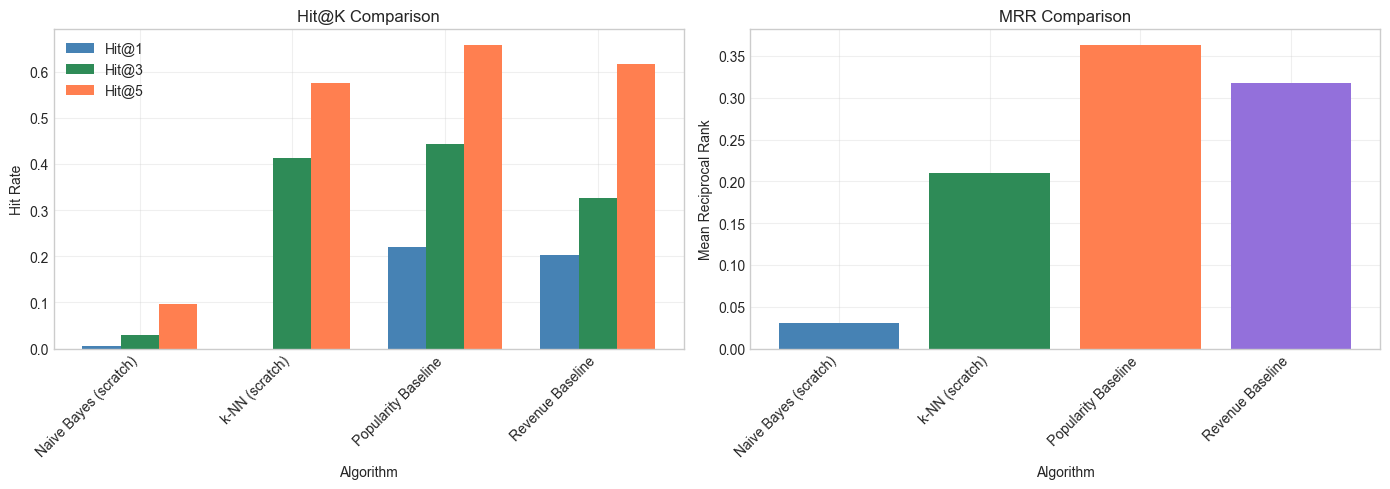

In [16]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hit@K comparison
x = np.arange(len(comparison_df))
width = 0.25

ax = axes[0]
ax.bar(x - width, comparison_df['Hit@1'], width, label='Hit@1', color='steelblue')
ax.bar(x, comparison_df['Hit@3'], width, label='Hit@3', color='seagreen')
ax.bar(x + width, comparison_df['Hit@5'], width, label='Hit@5', color='coral')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Hit Rate')
ax.set_title('Hit@K Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Algorithm'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# MRR comparison
ax = axes[1]
colors = ['steelblue', 'seagreen', 'coral', 'mediumpurple']
ax.bar(comparison_df['Algorithm'], comparison_df['MRR'], color=colors)
ax.set_xlabel('Algorithm')
ax.set_ylabel('Mean Reciprocal Rank')
ax.set_title('MRR Comparison')
plt.xticks(rotation=45, ha='right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/ranking_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Example Recommendations

In [17]:
# Show example recommendations for a few test receipts
print("Example Recommendations:")
print("=" * 80)

for i in range(min(5, len(X_test_eval))):
    receipt_id = test_receipt_ids_eval[i]
    actual_products = df[df['id_bon'] == receipt_id]['retail_product_name'].unique()
    
    # Get rankings
    nb_ranking = nb_ranker.rank(X_test_eval[i:i+1], top_k=3)[0]
    
    print(f"\nReceipt {receipt_id}:")
    print(f"  Actual products: {list(actual_products)[:5]}...")
    print(f"  Naive Bayes Top 3:")
    for p, score, prob in nb_ranking:
        marker = "✓" if p in actual_products else "✗"
        print(f"    {marker} {p}: Score={score:.2f}, P={prob:.2%}")

Example Recommendations:

Receipt 61770:
  Actual products: ['Breaded Chicken Schnitzel', 'Crazy Schnitzel', 'Extra parmezan', 'Aqua Carpatica Minerala 0.5L', 'Blueberry Sauce']...
  Naive Bayes Top 3:
    ✗ Crazy Fries with Cheddar Sauce and bacon: Score=25.90, P=100.00%
    ✗ Crazy Fries with Parmesan: Score=24.90, P=99.99%
    ✓ Baked potatoes: Score=12.90, P=100.00%

Receipt 72468:
  Actual products: ['Breaded Pork Schnitzel', 'Spicy Sauce', 'Aqua Carpatica Plata 0.5L', 'Baked potatoes']...
  Naive Bayes Top 3:
    ✗ French Fries with Parmesan: Score=32.90, P=100.00%
    ✗ Crazy Fries with Cheddar Sauce and bacon: Score=25.90, P=100.00%
    ✗ Crazy Fries with Parmesan: Score=24.90, P=100.00%

Receipt 72680:
  Actual products: ['Crazy Sauce', 'Breaded Pork Schnitzel', 'Aqua Carpatica Plata 0.5L', 'French fries']...
  Naive Bayes Top 3:
    ✗ French Fries with Parmesan: Score=32.90, P=100.00%
    ✗ Crazy Fries with Cheddar Sauce and bacon: Score=25.90, P=100.00%
    ✗ Crazy Fries wit

## 10. Summary

In [18]:
print("=" * 70)
print("RANKING SYSTEM SUMMARY")
print("=" * 70)
print(f"\nCandidate products: {len(CANDIDATE_PRODUCTS)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples evaluated: {eval_sample_size}")

print("\n" + "-" * 70)
print("PERFORMANCE COMPARISON")
print("-" * 70)
print(f"{'Algorithm':<25} {'Hit@1':<10} {'Hit@3':<10} {'Hit@5':<10} {'MRR':<10}")
print("-" * 70)
for _, row in comparison_df.iterrows():
    print(f"{row['Algorithm']:<25} {row['Hit@1']:<10.4f} {row['Hit@3']:<10.4f} {row['Hit@5']:<10.4f} {row['MRR']:<10.4f}")

# Find best algorithm
best_idx = comparison_df['MRR'].idxmax()
print(f"\nBest Algorithm (by MRR): {comparison_df.loc[best_idx, 'Algorithm']}")
print("=" * 70)

RANKING SYSTEM SUMMARY

Candidate products: 30
Training samples: 6295
Test samples evaluated: 200

----------------------------------------------------------------------
PERFORMANCE COMPARISON
----------------------------------------------------------------------
Algorithm                 Hit@1      Hit@3      Hit@5      MRR       
----------------------------------------------------------------------
Naive Bayes (scratch)     0.0060     0.0302     0.0967     0.0307    
k-NN (scratch)            0.0000     0.4125     0.5750     0.2104    
Popularity Baseline       0.2205     0.4441     0.6586     0.3635    
Revenue Baseline          0.2024     0.3263     0.6163     0.3177    

Best Algorithm (by MRR): Popularity Baseline
